# Variational Autoencoder
Implementation of a vanilla variational autoencoder based on Kingma, Welling, 2013 (https://arxiv.org/abs/1312.6114) and Rezende, Mohamed, Wierstra, 2013 (https://arxiv.org/abs/1401.4082).

## Background

### Latent variable model

We are interested in training a latent variable model $P_{\theta}(x, z)$, where $x$ are the observed variables, $z$ are the latent variable $z$ and with parameters $\theta$. However, typically both the marginal likelihood
\begin{equation}
p(x) = \int p(x|z)p(z) dz
\end{equation}
as well as the posterior over the latent variable
\begin{equation}
p(z|x) = \frac{p(x, z)}{p(x)}
\end{equation}
are intractable for all but the simplest models.

### The variational approximation

Since the marginal likelihood of the model is assumed to be intractable, we will maximize a lower bound on the marginal log-likelihood by introducing a variational posterior $q_{\phi}(z|x)$ with parameters $\phi$ to the true posterior $p_{\theta}(z|x)$ assumed to be in a parametric family with parameters $\theta$ ($\phi$ and $\theta$ are omitted in the following but could be inserted for every $q$ and $p$)
\begin{align}
\ln p(x) & = ln \int p(x|z) p(z) dz \\
& = ln \int p(x|z) p(z) \frac{1}{q(z|x)} q(z|x)dz \\
& \geq \int q(z|x) ln \frac{p(x|z)p(z)}{q(z|x)} \\
& = KL(q(z|x)||p(z)) + \mathbb{E}_{q(z|x)}[\ln p(x|z)] \\
& = \mathbb{E}_{q(z|x)}[\ln p(x, z) - \ln q(z)] = \mathcal{L}(x) \\
\end{align}

where the inequality in the second step is Jensen's inequality on the measure space $q(z)dz$.
$\mathcal{L}$ is known as the evidence lower bound (ELBO).

An alternative derivation of the ELBO can be done by looking at the KL divergence of the true and approximate posterior
\begin{align}
KL(q(z|x)|| p(z|x)) &= \int q(z|x) \ln \frac{q(z|x)}{p(z|x)} \\
&= \int q(z|x) \ln \frac{p(x)q(z|x)}{p(x, z)} \\
&= - \int q(z|x) \ln \frac{p(x, z)}{q(z|x)} + \int q(z|x) \ln p(x) \\
&= -\mathcal{L} + \ln p(x)
\end{align}
and thus $\ln p(x) \geq \mathcal{L}$ since the KL divergence is non-negative.
In the setting of the variational autoencoder we will typically consider the ELBO in the form
\begin{equation}
\mathcal{L} = KL(q(z|x)||p(z)) + \mathbb{E}_{q(z|x)}[\ln p(x|z)],
\end{equation}
where the first term can be understood as a regularization term that measure the deviation of the variational distribution $q(z|x)$ from the prior distribution $p(z)$ and the second term is a reconstruction error.
In the case of a Gaussian variational approximation the KL divergence can be calculated analytically.

### Optimizing the ELBO

The naive optimization of the ELBO using the Monte Carlo method requries estimating a term of the form
\begin{equation}
\nabla_{\theta}\mathbb{E}_{q_{\theta}(z|x)}[f(z)] = \mathbb{E}_{q_{\theta}(z|x)}[f(z) \nabla_{\theta} \ln q_{\theta}(z|x)].
\end{equation}
However, this estimate has a high variance and is thus inefficient.
Intuitively, this can be seen by the fact that the loss function $f$ is not differentiated directly in this approximation (only the variational posterior is differentiated).

For many cases, a more efficient way to calculate the gradients is called the **reparametrization trick** (Kingma, Welling, 2013) or **stochastic backpropagation** (Rezende, Mohamed, Wierstra, 2013):
If the random variable $z \sim q(z|x)$ can be reparametrized as a differentiable transformation $g(\varepsilon, x)$ of an auxiliary random variable $\varepsilon$ (noise variable), i.e.
\begin{equation}
z = g(\varepsilon, x) \qquad \text{with} \quad \varepsilon \sim p(\varepsilon),
\end{equation}
then
\begin{equation}
\mathbb{E}_{q(z|x)}[f(z)] = \mathbb{E}_{p(\varepsilon)}[f(g(\varepsilon, x)]
\end{equation}
and the derivative can be pulled inside the expectation.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time

## MNIST

As in Kingma, Welling, 2013 the MNIST dataset is used consisting of grayscale images of the digits 0-9 as images of size 28x28 (784 pixels in total).

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train = np.asarray(x_train / 255.0, dtype=np.float32)
x_test = np.asarray(x_test / 255.0, dtype=np.float32)
train_cat_idx = [np.where(y_train == i)[0] for i in range(0, 10)]
test_cat_idx = [np.where(y_test == i)[0] for i in range(0, 10)]
print('Image shape: {}'.format(x_train[0].shape))

Image shape: (28, 28)


In [3]:
def plot(samples, figsize=(10, 2), gspec=(1, 5)):
    # simple plotting utility for samples
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(*gspec)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample, cmap='Greys_r')

    return fig

Random examples for the different digits (classes):


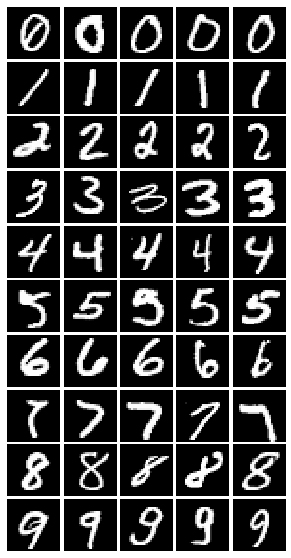

In [4]:
sample_idx = np.asarray([np.random.choice(x, 5) for x in train_cat_idx]).flatten()
print('Random examples for the different digits (classes):')
f = plot(x_train[sample_idx, :, :], figsize=(5, 10), gspec=(10, 5))

In [5]:
x_train_flat = x_train.reshape((-1, 784))
x_test_flat = x_test.reshape((-1, 784))

In [6]:
buffer_size = 60000
batch_size = 100
train_dataset = tf.data.Dataset.from_tensor_slices(x_train_flat).shuffle(buffer_size).batch(batch_size).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices(x_test_flat).batch(10000)
iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                           train_dataset.output_shapes)
next_element = iterator.get_next()
train_init_op = iterator.make_initializer(train_dataset)
test_init_op = iterator.make_initializer(test_dataset)

## The network
The variational autoencoder consists of parts:
- The encoder q(z|x) that maps the input x into a latent representation z which constitutes the variational approximation to the true posterior.
- The decoder p(x|z) uses a latent encoding to create an create a sample in the input space.

In [7]:
class VAE:
    
    def __init__(self, x, hidden_dim=500, latent_dim=2):
        self.x = x
        self.input_shape = x.get_shape().as_list()[1]
        self.hidden_dim = 500
        self.latent_dim = latent_dim
        
        # encoder
        self.z_mu, self.z_log_sig = self.build_encoder()
        self.z = self.sample_z(self.z_mu, self.z_log_sig)
        
        # decoder: use template to create two decoder for training and sampling
        build_decoder_template = tf.make_template('decoder', self.build_decoder)
        self.x_re_logits, self.x_re = build_decoder_template(self.z)
        self.z_placeholder = tf.placeholder(tf.float32, shape=(None, self.latent_dim))
        _, self.x_re_from_placeholder = build_decoder_template(self.z_placeholder)
  
        self.loss = self.build_loss()
        
    def build_encoder(self):
        # aka recognition model
        h = tf.layers.dense(self.x, self.hidden_dim, activation=tf.nn.relu)
        z_mu = tf.layers.dense(h, self.latent_dim)
        z_log_sig = tf.layers.dense(h, self.latent_dim)
        return z_mu, z_log_sig
    
    @staticmethod
    def sample_z(z_mu, z_log_sig):
        eps = tf.random_normal(shape=tf.shape(z_mu))
        return z_mu + tf.exp(z_log_sig / 2.) * eps
        
    
    def build_decoder(self, z):
        # aka the generative model
        h = tf.layers.dense(z, self.hidden_dim, activation=tf.nn.relu)
        logits = tf.layers.dense(h, self.input_shape)
        probs = tf.nn.sigmoid(logits)
        return logits, probs
    
    def build_loss(self):
        rec_error = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.x_re_logits, labels=self.x), 1)
        kl_error = 0.5 * tf.reduce_sum(self.z_mu ** 2 + tf.exp(self.z_log_sig) - self.z_log_sig - 1., 1)
        loss = tf.reduce_mean(rec_error + kl_error)
        return loss

In [8]:
vae = VAE(next_element, hidden_dim=500)
solver = tf.train.AdamOptimizer().minimize(vae.loss)

In [9]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [10]:
num_it = 30000
log_steps = 5000
tr_loss = np.zeros(num_it)
# pred = np.zeros((num_it // log_steps + 1, 10000, 784)) # maybe a bit of waste of resources ...
t_0 = time.time()

sess.run(train_init_op)
log_step = 0
for it in range(num_it):
    
    _, tr_loss[it] = sess.run([solver, vae.loss])
    
    if (it + 1) % log_steps == 0 or it == 0:
        t = time.time()
        print('Iter: {}'.format(it+1))
        print('Loss: {:.4f}'.format(tr_loss[it]))
        print('Total runtime {:.2f}s'.format(t - t_0))
        print()
        # sess.run(test_init_op)
        # pred[log_step, :, :] = sess.run(vae.x_re)
        # sess.run(train_init_op)
        # log_step += 1

Iter: 1
Loss: 544.3492
Total runtime 0.63s

Iter: 5000
Loss: 158.3654
Total runtime 58.07s

Iter: 10000
Loss: 143.6313
Total runtime 105.18s

Iter: 15000
Loss: 151.2858
Total runtime 153.81s

Iter: 20000
Loss: 144.6018
Total runtime 203.48s

Iter: 25000
Loss: 149.3451
Total runtime 253.94s

Iter: 30000
Loss: 146.4959
Total runtime 304.44s



Text(0, 0.5, 'Loss')

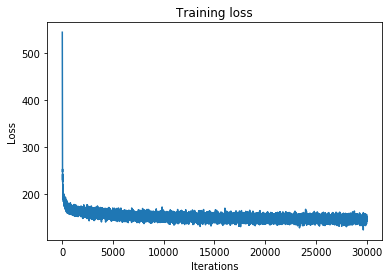

In [11]:
plt.plot(tr_loss)
plt.title('Training loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')

In [12]:
sess.run(test_init_op)
[x, z_mu, x_re] = sess.run([next_element, vae.z_mu, vae.x_re])

Reconstruction samples:


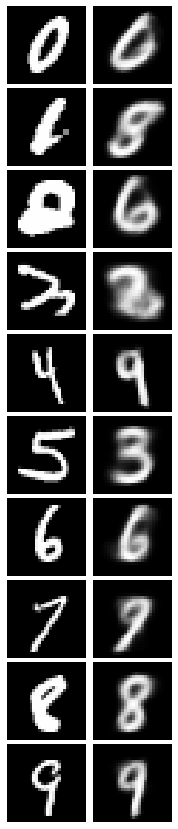

In [13]:
sample_idx = np.asarray([np.random.choice(x, 1) for x in test_cat_idx]).flatten()
tmp = np.concatenate((x[sample_idx, :].reshape((-1, 28, 28)), x_re[sample_idx, :].reshape((-1, 28, 28))))
idx = np.arange(20).reshape((2, 10)).transpose().flatten()
tmp = tmp[idx, :]
print('Reconstruction samples:')
fig = plot(tmp, figsize=(3, 15), gspec=(10, 2))

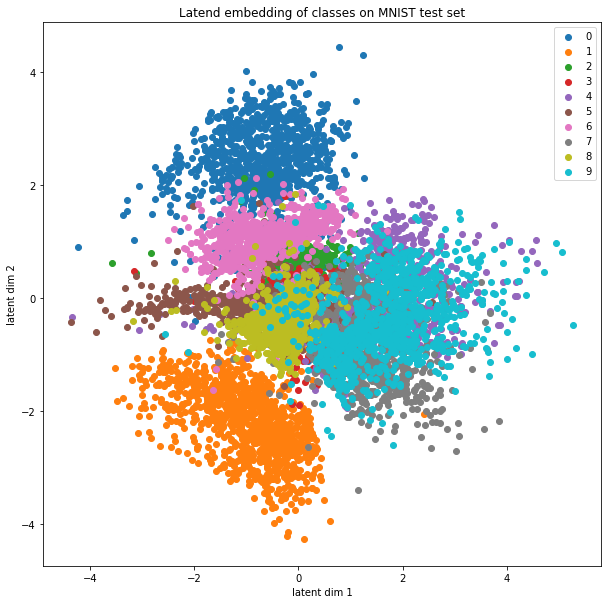

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for g in np.unique(y_test):
    idx = np.where(y_test == g)[0]
    ax.scatter(z_mu[idx, 0], z_mu[idx, 1], label=g)
ax.legend()
plt.xlabel('latent dim 1')
plt.ylabel('latent dim 2')
plt.title('Latend embedding of classes on MNIST test set')
plt.show()

In [15]:
xx, yy = np.meshgrid(np.arange(-2, 3), np.arange(2, -3, -1))
z = np.concatenate((xx.reshape((-1, 1)), yy.reshape((-1, 1))), axis=1)
samples = sess.run(vae.x_re_from_placeholder, feed_dict={vae.z_placeholder: z})

Samples on a grid from -2,...,2
Compare this with the embedding of the classes in the latent space above


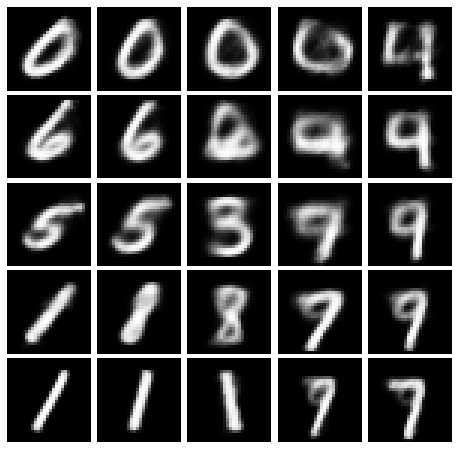

In [16]:
print('Samples on a grid from -2,...,2')
print('Compare this with the embedding of the classes in the latent space above')
fig = plot(samples.reshape((-1, 28, 28)), figsize=(8, 8), gspec=(5, 5))